In [0]:
# notebook settings -> GPU
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split
import matplotlib.pylab as plt
from sklearn.metrics import f1_score
from sklearn.naive_bayes import MultinomialNB

from nltk import word_tokenize, sent_tokenize
import nltk
nltk.download('punkt')

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from gensim.models.word2vec import Word2Vec
from gensim.models import KeyedVectors

# Keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Flatten, LSTM, Conv1D, MaxPooling1D, Dropout, Activation, GlobalMaxPooling1D, Bidirectional, GRU, CuDNNGRU
from keras.layers.embeddings import Embedding
import tensorflow_datasets as tfds


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


Using TensorFlow backend.


In [0]:
# Split the training set into 60% and 40%, so we'll end up with 15,000 examples
# for training, 10,000 examples for validation and 25,000 examples for testing.
train_validation_split = tfds.Split.TRAIN.subsplit([6, 4])

(train_data, validation_data), test_data = tfds.load(
    name="imdb_reviews", 
    split=(train_validation_split, tfds.Split.TEST),
    as_supervised=True)

df_train = pd.DataFrame(list(tfds.as_numpy(train_data)),columns=['texto','clase'])
df_dev = pd.DataFrame(list(tfds.as_numpy(validation_data)),columns=['texto','clase'])
df_test = pd.DataFrame(list(tfds.as_numpy(test_data)),columns=['texto','clase'])

Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/0.1.0. Subsequent calls will reuse this data.


In [0]:
def format_and_clean(text):
    text = text.decode('utf-8').lower()
    # clean review
    text = re.sub('<.*?>',' ',text)
    return text


In [0]:
X_train_text = df_train.texto.apply(format_and_clean)
X_dev_text = df_dev.texto.apply(format_and_clean)
X_test_text = df_test.texto.apply(format_and_clean)

In [0]:
y_train = df_train.clase
y_dev = df_dev.clase
y_test = df_test.clase

In [0]:
vocab_size = 5000+1 # Adding 1 because of reserved 0 index
tokenizer = Tokenizer(num_words=vocab_size-1)
tokenizer.fit_on_texts(X_train_text)
X_train = tokenizer.texts_to_sequences(X_train_text)
X_dev = tokenizer.texts_to_sequences(X_dev_text)
X_test = tokenizer.texts_to_sequences(X_test_text)

In [0]:
print(X_train_text.iloc[2])
print("-------------------------------------------------------------------------")
print(X_train[2])

i saw this film on true movies (which automatically made me sceptical) but actually - it was good. why? not because of the amazing plot twists or breathtaking dialogue (of which there is little) but because actually, despite what people say i thought the film was accurate in it's depiction of teenagers dealing with pregnancy.  it's not dawson's creek, they're not graceful, cool witty characters who breeze through sexuality with effortless knowledge. they're kids and they act like kids would.   they're blunt, awkward and annoyingly confused about everything. yes, this could be by accident and they could just be bad actors but i don't think so. dermot mulroney gives (when not trying to be cool) a very believable performance and i loved him for it. patricia arquette is whiny and annoying, but she was pregnant and a teenagers? the combination of the two isn't exactly lavender on your pillow. the plot was very predictable and but so what? i believed them, his stress and inability to cope - 

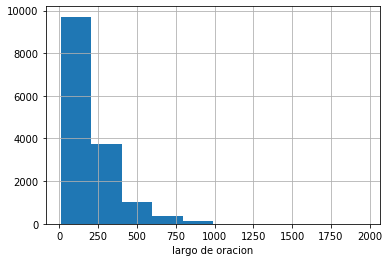

In [0]:

pd.Series([len(x)for x in X_train]).hist()
plt.xlabel('largo de oracion');


In [0]:
# Fijamos el numero de tokens por instancia. Si tiene mas de 'maxlen' se recorta, si tiene menos se completa con ceros (padding)
maxlen=500
X_train_padded = pad_sequences(X_train,padding='post',maxlen=maxlen)
X_dev_padded   = pad_sequences(X_dev,padding='post',maxlen=maxlen)
X_test_padded  = pad_sequences(X_test,padding='post',maxlen=maxlen)

In [0]:
print(X_dev_padded[2])

[ 648    1 4862    6  372    1   87  118  750  119    7 1152 1773   20
   62    6    1  199 4105    4    2 1788   42 4105    4    3 1438   13
  256  872 1376  725  462  554    6 1187    3  194 2049    3 2940    4
    3 3018 1290   15    3 3523  524    4    3  317    2  102 4386  831
  355  560    7   22 4359    8    1    4  933  187  159   30    1   90
   20   62    6 1187    3  232   77   31   15    3 1071    4 2216  316
  412 1580   14   42   20    1  192   11 1187    6    3  425    4 4386
  831   11   69    2  678   62   69 3447  101    5   26   33    2   47
   32   21  204    6  139  295  244  957 2095   17 1380    2   23    4
  270  931   24   20  324 1651  175    5 1187    2   23 1071   13   32
  889   24   32   56 3496    5 1870   97 2949   83    1  198 2191  661
    4   56  536  784    3 1054    1 3548  301 1380    2   23 4327 1092
    2 3611 3885    7    1  169   90   11 1187   23  317    2   56   23
 1177   78 1262   99 1262   38  141    9  132 3396   99 3396   38    6
    8 

# Naive Bayes

In [0]:
count_vect = CountVectorizer(tokenizer=word_tokenize, max_features=5000)
X_train_NB = count_vect.fit_transform(X_train_text) # cuenta frecuencia de tokens y define el diccionario
X_dev_NB= count_vect.transform(X_dev_text) # cuenta frecuencia de tokens existentes en el diccionario


In [0]:
clf = MultinomialNB(alpha=1) # alpha es el smoothing parameter
NB_model = clf.fit(X_train_NB,y_train)
NB_F1 = f1_score(y_dev,NB_model.predict(X_dev_NB))
NB_F1

0.822088394406451

## Recurrent Neural Network

In [0]:
embedding_dim = 100

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, input_length=maxlen))
model.add(CuDNNGRU(128))
model.add(Dense(10, activation='relu'))
model.add(Dense(10, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy',  metrics=['accuracy'])

In [0]:
# train
history = model.fit(X_train_padded, y_train,batch_size=100, epochs=15,validation_data=(X_dev_padded, y_dev)) 


Train on 15000 samples, validate on 10000 samples
Epoch 1/15
15000/15000 [==============================] - 6s 404us/step - loss: 0.6933 - acc: 0.5037 - val_loss: 0.6931 - val_acc: 0.5024
Epoch 2/15
15000/15000 [==============================] - 5s 363us/step - loss: 0.6939 - acc: 0.5141 - val_loss: 0.6920 - val_acc: 0.5013
Epoch 3/15
15000/15000 [==============================] - 6s 370us/step - loss: 0.6833 - acc: 0.5182 - val_loss: 0.6954 - val_acc: 0.5044
Epoch 4/15
15000/15000 [==============================] - 6s 375us/step - loss: 0.6717 - acc: 0.5232 - val_loss: 0.7062 - val_acc: 0.5059
Epoch 5/15
15000/15000 [==============================] - 6s 380us/step - loss: 0.6605 - acc: 0.5237 - val_loss: 0.7262 - val_acc: 0.5057
Epoch 6/15
15000/15000 [==============================] - 6s 385us/step - loss: 0.6566 - acc: 0.5323 - val_loss: 0.7311 - val_acc: 0.5052
Epoch 7/15
15000/15000 [==============================] - 6s 387us/step - loss: 0.6538 - acc: 0.5331 - val_loss: 0.7483 - 

In [0]:
def plot_history(history):
  # Plot training & validation accuracy values
  plt.plot(history.history['acc'])
  plt.plot(history.history['val_acc'])
  plt.title('Model accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Test'], loc='upper left')
  plt.show()

  # Plot training & validation loss values
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('Model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Test'], loc='upper left')
  plt.show()


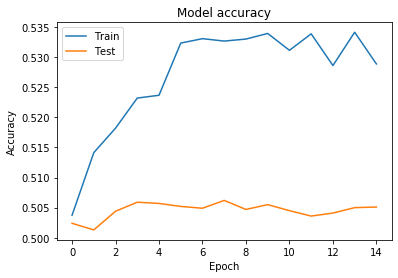

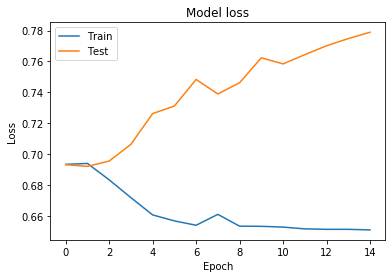

In [0]:
plot_history(history)

In [0]:
embedding_dim = 100
model_bigru = Sequential()
model_bigru.add(Embedding(vocab_size, embedding_dim, input_length=maxlen))
model_bigru.add(Bidirectional(CuDNNGRU(128, return_sequences = True)))
model_bigru.add(Bidirectional(CuDNNGRU(128)))
model_bigru.add(Dense(10, activation='relu'))
model_bigru.add(Dense(10, activation='relu'))
model_bigru.add(Dense(1, activation='sigmoid'))
model_bigru.compile(optimizer='adam', loss='binary_crossentropy',  metrics=['accuracy'])

In [0]:
history = model_bigru.fit(X_train_padded, y_train,batch_size=100, epochs=15,validation_data=(X_dev_padded, y_dev)) 


Train on 15000 samples, validate on 10000 samples
Epoch 1/15
15000/15000 [==============================] - 28s 2ms/step - loss: 0.6933 - acc: 0.4960 - val_loss: 0.6932 - val_acc: 0.4982
Epoch 2/15
15000/15000 [==============================] - 26s 2ms/step - loss: 0.6932 - acc: 0.4973 - val_loss: 0.6932 - val_acc: 0.4982
Epoch 3/15
15000/15000 [==============================] - 26s 2ms/step - loss: 0.6930 - acc: 0.5012 - val_loss: 0.6913 - val_acc: 0.4982
Epoch 4/15
15000/15000 [==============================] - 26s 2ms/step - loss: 0.6306 - acc: 0.6408 - val_loss: 0.5670 - val_acc: 0.7160
Epoch 5/15
15000/15000 [==============================] - 27s 2ms/step - loss: 0.4649 - acc: 0.7899 - val_loss: 0.4115 - val_acc: 0.8217
Epoch 6/15
15000/15000 [==============================] - 27s 2ms/step - loss: 0.3672 - acc: 0.8413 - val_loss: 0.3449 - val_acc: 0.8539
Epoch 7/15
15000/15000 [==============================] - 27s 2ms/step - loss: 0.2679 - acc: 0.8945 - val_loss: 0.3143 - val_acc

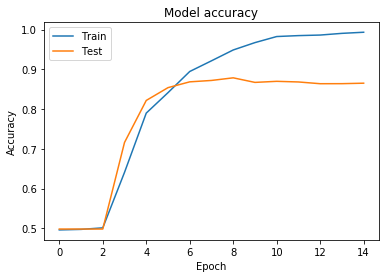

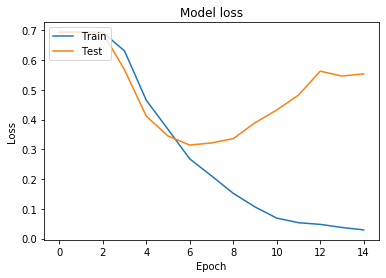

In [0]:
plot_history(history)

In [0]:
pred_bigru = model.predict(X_dev_padded)
bigru_F1 = f1_score(y_dev,pred_bigru[:,0]>0.5)
bigru_F1

0.8659711872826628

## Pre-trained embeddings

In [0]:
!wget https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz

--2019-11-27 00:26:49--  https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.129.197
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.129.197|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1647046227 (1.5G) [application/x-gzip]
Saving to: ‘GoogleNews-vectors-negative300.bin.gz’

GoogleNews-vectors- 100%[===================>]   1.53G  11.3MB/s    in 2m 24s  

2019-11-27 00:29:15 (10.9 MB/s) - ‘GoogleNews-vectors-negative300.bin.gz’ saved [1647046227/1647046227]



In [0]:
#load model
w2v_model = KeyedVectors.load_word2vec_format('./GoogleNews-vectors-negative300.bin.gz', binary=True)

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:402: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [0]:
# create a weight matrix for words in training docs
embedding_matrix = np.zeros((vocab_size, 300))
for word, i in tokenizer.word_index.items():
    if i < vocab_size and word in w2v_model:
        embedding_matrix[i] = w2v_model[word]

In [0]:
model_bigru_emb = Sequential()
model_bigru_emb.add(Embedding(vocab_size, 300, weights=[embedding_matrix], input_length=maxlen, trainable=False))
model_bigru_emb.add(Bidirectional(CuDNNGRU(128, return_sequences = True)))
model_bigru_emb.add(Dropout(0.3))
model_bigru_emb.add(Bidirectional(CuDNNGRU(128)))
model_bigru_emb.add(Dropout(0.3))
model_bigru_emb.add(Dense(10, activation='relu'))
model_bigru_emb.add(Dense(10, activation='relu'))
model_bigru_emb.add(Dense(1, activation='sigmoid'))
model_bigru_emb.compile(optimizer='adam', loss='binary_crossentropy',  metrics=['accuracy'])

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [0]:
history_emb = model_bigru_emb.fit(X_train_padded,y_train,epochs=15,validation_data=(X_dev_padded,y_dev),batch_size=100)

Train on 15000 samples, validate on 10000 samples
Epoch 1/15
15000/15000 [==============================] - 29s 2ms/step - loss: 0.6571 - acc: 0.6299 - val_loss: 0.6102 - val_acc: 0.6992
Epoch 2/15
15000/15000 [==============================] - 28s 2ms/step - loss: 0.5788 - acc: 0.7389 - val_loss: 0.5602 - val_acc: 0.7924
Epoch 3/15
15000/15000 [==============================] - 27s 2ms/step - loss: 0.5158 - acc: 0.7793 - val_loss: 0.4293 - val_acc: 0.8490
Epoch 4/15
15000/15000 [==============================] - 28s 2ms/step - loss: 0.3924 - acc: 0.8648 - val_loss: 0.3707 - val_acc: 0.8600
Epoch 5/15
15000/15000 [==============================] - 28s 2ms/step - loss: 0.3435 - acc: 0.8756 - val_loss: 0.3277 - val_acc: 0.8788
Epoch 6/15
15000/15000 [==============================] - 28s 2ms/step - loss: 0.3064 - acc: 0.8882 - val_loss: 0.3364 - val_acc: 0.8638
Epoch 7/15
15000/15000 [==============================] - 28s 2ms/step - loss: 0.3065 - acc: 0.8825 - val_loss: 0.3085 - val_acc

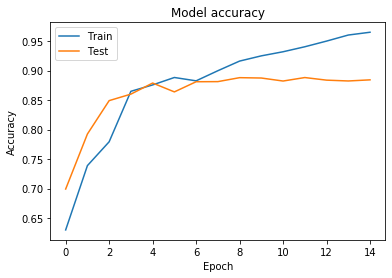

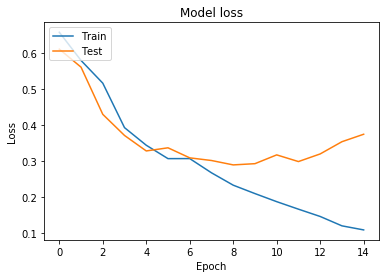

In [0]:
plot_history(history_emb)

In [0]:
pred_bigru_emb = model_bigru_emb.predict(X_dev_padded)
bigru_emb_F1 = f1_score(y_dev,pred_bigru_emb[:,0]>0.5)
bigru_emb_F1

0.8862698880377136

# En test

In [0]:
pred_y= model_bigru_emb.predict(X_test_padded)
test_F1 = f1_score(y_test,pred_y[:,0]>0.5)
test_F1

0.8804593149871311